In [1]:
import numpy
import torch
import torch as th
import torch.nn.functional as F

In [2]:
# Thanks for StructTrans
# https://github.com/jingraham/neurips19-graph-protein-design
def nan_to_num(tensor: torch.Tensor, nan=0.0) -> torch.Tensor:
    return tensor.masked_fill_(torch.isnan(tensor), nan)
     
 
def _normalize(tensor: torch.Tensor, dim=-1) -> torch.Tensor:
    return nan_to_num(F.normalize(tensor, dim=dim))


In [3]:
def _quaternions(R: th.Tensor) -> th.Tensor:
    """((...), 3, 3) -> ((...), 4)"""
    ii, ij, ik, ji, jj, jk, ki, kj, kk = th.unbind(R.reshape(*R.shape[:-2], -1), -1)

    qi = +ii - jj - kk
    qj = -ii + jj - kk
    qk = -ii - jj + kk

    proto_q = th.stack((qi, qj, qk), dim=-1)
    magnitudes = proto_q.add_(1.0).abs().sqrt().mul_(0.5)

    signs = th.stack([kj - jk, ik - ki, ji - ij], -1).sign()
    xyz = signs * magnitudes
    w = F.relu(1 + ii + jj + kk).sqrt().mul_(0.5)
    Q = th.cat((xyz, w[..., None]), -1)

    return _normalize(Q, dim=-1)


In [4]:
def quaternions(R):
    _R = lambda i,j: R[:,i,j]
    
    qi = +_R(0,0) - _R(1,1) - _R(2,2)
    qj = -_R(0,0) + _R(1,1) - _R(2,2) 
    qk = -_R(0,0) - _R(1,1) + _R(2,2)
    
    proto_q = th.stack((qi, qj, qk), dim=-1)
    
    magnitudes = (proto_q + 1.0).abs().sqrt().mul_(0.5)
    
    signs = th.stack([
       _R(2,1) - _R(1,2),
       _R(0,2) - _R(2,0), 
       _R(1,0) - _R(0,1)    
    ], -1).sign()
    
    xyz = signs * magnitudes
    w = F.relu(1 + _R(0,0) + _R(1,1) + _R(2,2)).sqrt().mul_(0.5)
    
    Q = th.cat((xyz, w[..., None]), -1)
    
    return _normalize(Q, dim=-1)


In [5]:
# Dummy R tensor input 
R = th.randn(5, 3, 3)
#print("R = ", R)

In [6]:
import matplotlib.pyplot as plt 
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D

def plot_quaternion(qs):
    # Plot results
    style.use('ggplot')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  

    for q in qs:
        x = q[0].item()
        y = q[1].item()
        z = q[2].item()
        ax.quiver(0, 0, 0, x, y, z, color='r')  

    ax.set_xlim3d(-1, 1)  
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    plt.show()

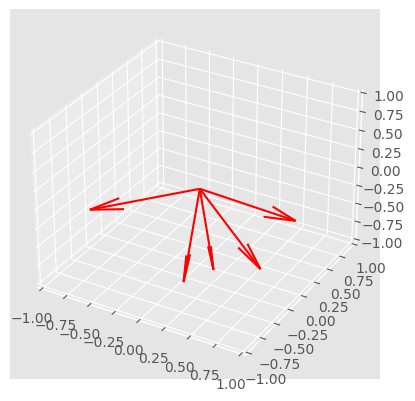

In [7]:
# Calculate quaternions
qs = _quaternions(R)

plot_quaternion(qs)

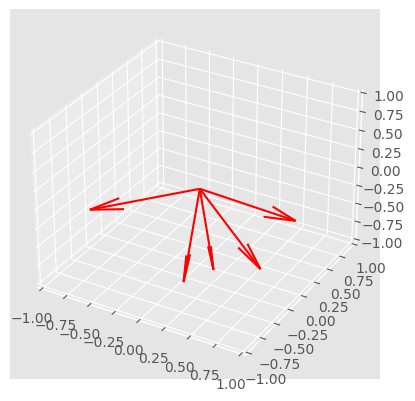

In [8]:
# Calculate quaternions
qs = quaternions(R)

plot_quaternion(qs)